### 參考文章：[Kaggle競賽-鐵達尼號生存預測(Top 3%)](https://medium.com/@yulongtsai/https-medium-com-yulongtsai-titanic-top3-8e64741cc11f)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)

In [2]:
train_df = pd.read_csv('/Users/john.tung/Downloads/titanic/train.csv')
test_df = pd.read_csv('/Users/john.tung/Downloads/titanic/test.csv')
data_df = train_df.append(test_df)
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Sex,Survived
0,female,0.742
1,male,0.189


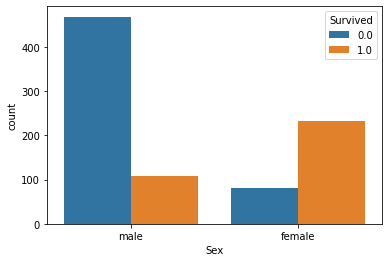

In [3]:
sns.countplot(data_df['Sex'], hue=data_df['Survived'])
data_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().round(3)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


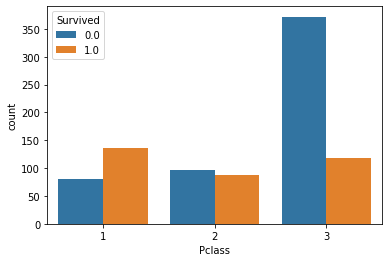

In [4]:
sns.countplot(data_df['Pclass'], hue=data_df['Survived'])
data_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().round(3)

In [5]:
# 將性別資料轉為 0 1，0 為女性，1 為男性
data_df['Sex_Code'] = data_df['Sex'].map({'female':0, 'male':1}).astype('int')
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [6]:
# 分開訓練和測試集
train_df = data_df[:len(train_df)]
test_df = data_df[len(train_df):]

In [7]:
# 生還與否設定為目標 Y，其餘為訓練資料 X
X = train_df.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = train_df['Survived']

In [8]:
# Show Bseline
Base = ['Sex_Code', 'Pclass']
Base_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score: %.5f' %(Base_Model.oob_score_))

Base oob score: 0.73176


In [16]:
Predict = Base_Model.predict(test_df[Base])
Predict_result = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':Predict}).astype(int)
Predict_result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [17]:
Predict_result.to_csv('submission.csv', index=False)

## 加入票價

Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

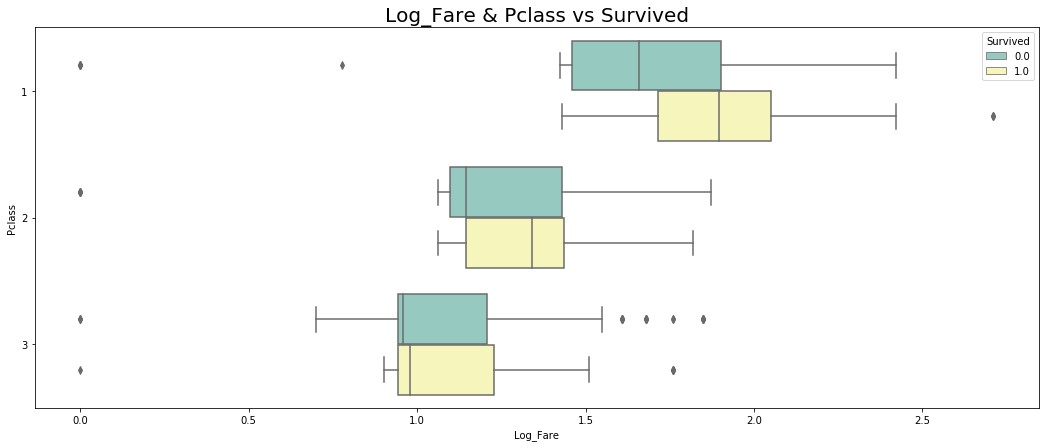

In [9]:
fig, ax = plt.subplots(figsize=(18, 7))
data_df['Log_Fare'] = (data_df['Fare']+1).map(lambda x:np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare', hue='Survived', data=data_df, orient='h',
           ax=ax, palette='Set3')
ax.set_title('Log_Fare & Pclass vs Survived', fontsize=20)
pd.pivot_table(data_df, values=['Fare'], index=['Pclass'], columns=['Survived'], aggfunc='median').round(3)

從表和圖中可以看出存活下來的乘客確實平均而言付出較高的票價，決定測試這個特徵
然而，測試之前需要將票價切分成幾個區間，才不會讓模型 overfit 太嚴重
如此問題就來了，切成幾塊比較合適呢?

首先填補缺失值，由於只有一項，填入中位數

In [10]:
# filling missing values
data_df['Fare'] = data_df['Fare'].fillna(data_df['Fare'].median())

用極限的觀點來考慮區間切分問題 :
   * 當切分的區間太少時，區間內的資料太多一起平均，這樣沒有辦法看出差異性，使得特徵失真
   * 當切分區間太多時，一點點票價的不同，都影響了生存率的高低，如此一來很明顯地會overfitting，並且，切分區間趨近於無限大時，就回到了原本的數值特徵

下列程式碼將票價分別切分成 4, 5, 6 的區間，並命名為新的特徵

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


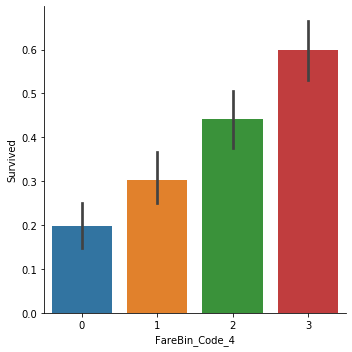

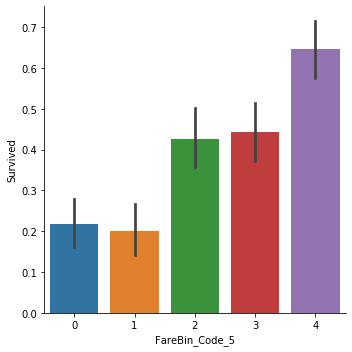

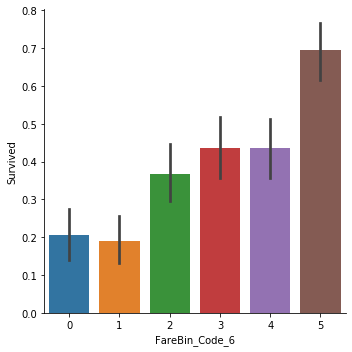

In [12]:
# Making Bins
data_df['FareBin_4'] = pd.qcut(data_df['Fare'], 4)
data_df['FareBin_5'] = pd.qcut(data_df['Fare'], 5)
data_df['FareBin_6'] = pd.qcut(data_df['Fare'], 6)

label = LabelEncoder()
data_df['FareBin_Code_4'] = label.fit_transform(data_df['FareBin_4'])
data_df['FareBin_Code_5'] = label.fit_transform(data_df['FareBin_5'])
data_df['FareBin_Code_6'] = label.fit_transform(data_df['FareBin_6'])

# cross tab
df_4 = pd.crosstab(data_df['FareBin_Code_4'],data_df['Pclass'])
df_5 = pd.crosstab(data_df['FareBin_Code_5'],data_df['Pclass'])
df_6 = pd.crosstab(data_df['FareBin_Code_6'],data_df['Pclass'])

display_side_by_side(df_4, df_5, df_6)

# plots
# fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True)
# fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5, linestyle='dashed', c='black', alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=data_df,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=data_df,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=data_df,kind='bar',ax=ax3)

# close FacetGrid object
# plt.close(g1.fig)
# plt.close(g2.fig)
# plt.close(g3.fig)

Pandas 中提供了蠻多種切分數值特徵的方式，這裡選用 qcut，qcut 是以累積百分比來切分的

例如將副指令 = 4，就會以 0% ~ 25%, 25% ~ 50%, 50% ~ 75%, 75% ~ 100% 來切分資料

好處是我們可以避免某個區間內的資料過少(skew problem)

In [13]:
# splits again beacuse we just engineered new feature
train_df = data_df[:len(train_df)]
test_df = data_df[len(train_df):]

# Training set and labels
X = train_df.drop(labels=['Survived', 'PassengerId'],axis=1)
Y = train_df['Survived']

# show columns
X.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Sex_Code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

In [14]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code,Log_Fare,FareBin_4,FareBin_5,FareBin_6,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]",3,4,5
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
